# Code embedding using Keras

In [5]:
#TODO add keras history plot

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
font = {'weight': 'bold', 'size': 20}
plt.rc('font', **font)

## Load data

In [12]:
dataframe = pd.read_json('../../data/full_data.json')

In [13]:
dataframe.head(2)

,data_source,label,file_name,is_header,content
0,crypto-library,1,nettle/eddsa-hash.c,False,/* eddsa-hash.c\n\n Copyright (C) 2014 Niels...
1,crypto-library,1,nettle/twofishdata.c,False,/* twofishdata.c\n\n Generates the permutati...


In [14]:
'{:,}'.format(len(dataframe))

'10,749'

Target value:

In [15]:
dataframe.label.value_counts()

0    9465
1    1284
Name: label, dtype: int64

Remove comments:

Grab docs (code submissions) and labels (correct or not):

In [16]:
import re

def remove_comments(string):
    # remove all occurrences streamed comments (/*COMMENT */) from string
    string = re.sub(re.compile(r"/\*.*?\*/",re.DOTALL ) , "" , string) 
    # remove all occurrence single-line comments (//COMMENT\n ) from string
    string = re.sub(re.compile(r"//.*?\n" ) , "" , string)
    return string


def get_docs_and_labels(df):
    _docs = []
    _labels = []
    for index in df.index:
        # Program
        
        code = remove_comments(
            df.at[index, 'content']
        )
        _docs.append(code)
        # Label
        label = int(df.at[index, 'label'])
        _labels.append(label)
    return _docs, _labels

In [17]:
docs, labels = get_docs_and_labels(dataframe)

In [18]:
'{:,}'.format(len(docs))

'10,749'

In [19]:
for item in dataframe.loc[1:1,'content'].iteritems():
    print(item)

(1, '/* twofishdata.c\n\n   Generates the permutations q0 and q1 for twofish.\n\n   Copyright (C) 1999 Ruud de Rooij <ruud@debian.org>\n\n   This program is free software; you can redistribute it and/or modify\n   it under the terms of the GNU General Public License as published by\n   the Free Software Foundation; either version 2 of the License, or\n   (at your option) any later version.\n\n   This program is distributed in the hope that it will be useful,\n   but WITHOUT ANY WARRANTY; without even the implied warranty of\n   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the\n   GNU General Public License for more details.\n\n   You should have received a copy of the GNU General Public License\n   along with this program; if not, write to the Free Software\n   Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA\n   02111-1301  USA.\n */\n\n#include <stdio.h>\n\n#define ror4(x) (((x) >> 1) | (((x) & 1) << 3))\n\nstatic unsigned char q0(unsigned char x)\n{\n    st

## Tokenize code and generate sequences

In [20]:
import os
#To ignore the warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.
/Users/arnaudstiegler/miniconda3/envs/emotion_detection/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/arnaudstiegler/miniconda3/envs/emotion_detection/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/arnaudstiegler/miniconda3/envs/emotion_detection/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qi

In [21]:
#We set the size of the vocabulary
NUM_WORDS = 10000

In [22]:
tokenizer = Tokenizer(num_words=NUM_WORDS, 
                     filters='\t\n,', 
                     lower=True, 
                     split=' ', 
                     char_level=False)

In [23]:
tokenizer.fit_on_texts(docs)

In [24]:
# Size of the vocabulary
len(tokenizer.word_index) 

1104144

In [25]:
# document_count: an integer count of the total number of documents that were used to fit the Tokenizer.
'Number docs: {:,}'.format(tokenizer.document_count)

'Number docs: 10,749'

In [26]:
# Number of occurences of if in the dataset
tokenizer.word_counts['if'] # index

122415

In [27]:
# word_docs: a dictionary of words and how many documents each appeared in.
tokenizer.word_docs['if']

5697

In [28]:
sequences = tokenizer.texts_to_sequences(docs)

Let's look at the length distribution of the sequences to know what max size to choose

In [29]:
len_seqs = [len(s) for s in sequences]
np.mean(len_seqs), np.std(len_seqs), np.max(len_seqs)

(522.2855149316215, 3081.647440494642, 152085)

The mean is at 600 but the standard deviation is much bigger

In [30]:
MAX_LENGTH = 1000

Dictionary to transform a vector back to the program:

In [31]:
id_to_word = { v: k for k, v in tokenizer.word_index.items() }

In [32]:
id_to_word[1]

'='

In [33]:
[id_to_word[index] for index in sequences[0]][0:10]

['#if',
 'have_config_h',
 '#',
 'include',
 '"config.h"',
 '#endif',
 '#include',
 '<assert.h>',
 '#include',
 '#include']

Pad documents:

In [34]:
from keras.preprocessing.sequence import pad_sequences
# pad documents
padded_docs = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [35]:
padded_docs[0][0:10]

array([  52, 1514,   85,  574, 1573,   23,   12, 1279,   12,   12],
      dtype=int32)

## Defining the model

In [39]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding

#We add the epsilon to avoid any error in the function

def precision_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def recall_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f2(y_true, y_pred):
    
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 5*((precision*recall)/(4*precision+recall+K.epsilon()))

In [40]:
# define the model
model = Sequential()
model.add(Embedding(NUM_WORDS, 50, input_length=MAX_LENGTH))
model.add(Flatten())
model.add(Dropout(rate=0.3))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['acc', f1,f2,precision_,recall_])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 50)          500000    
_________________________________________________________________
flatten (Flatten)            (None, 50000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 550,001
Trainable params: 550,001
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
    acc = history.history['recall_']
    val_acc = history.history['val_recall_']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(len(acc))

    plt.title('Training and validation recall')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.savefig('../code_embedding/plots/training_recall.png')

    _ = plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../code_embedding/plots/training_loss.png')

In [42]:
from sklearn.model_selection import train_test_split

indices = np.arange(padded_docs.shape[0])

X_train, X_test, y_train, y_test,train_idx, test_idx = train_test_split(padded_docs, labels,indices, 
                                                    test_size=0.2, random_state=0,
                                                    stratify=labels)

In [43]:
#Checking the indexing
(X_test[0] == padded_docs[test_idx[0]]).all()

True

In [44]:
# fit the model

history = model.fit(X_train, 
          y_train,
          epochs=5,
          validation_data=(X_test,y_test))

Train on 8599 samples, validate on 2150 samples
Epoch 1/5
8599/8599 [==============================] - 7s 843us/sample - loss: 0.1854 - acc: 0.9306 - f1: 0.5298 - f2: 0.4985 - precision_: 0.6510 - recall_: 0.4848 - val_loss: 0.0907 - val_acc: 0.9712 - val_f1: 0.8620 - val_f2: 0.8565 - val_precision_: 0.8923 - val_recall_: 0.8571
Epoch 2/5
8599/8599 [==============================] - 6s 746us/sample - loss: 0.0620 - acc: 0.9800 - f1: 0.8847 - f2: 0.8672 - precision_: 0.9380 - recall_: 0.8601 - val_loss: 0.0768 - val_acc: 0.9753 - val_f1: 0.8928 - val_f2: 0.8931 - val_precision_: 0.9111 - val_recall_: 0.8980
Epoch 3/5
8599/8599 [==============================] - 7s 789us/sample - loss: 0.0356 - acc: 0.9881 - f1: 0.8995 - f2: 0.8861 - precision_: 0.9368 - recall_: 0.8798 - val_loss: 0.0692 - val_acc: 0.9721 - val_f1: 0.8040 - val_f2: 0.7817 - val_precision_: 0.8643 - val_recall_: 0.7706
Epoch 4/5
8599/8599 [==============================] - 7s 845us/sample - loss: 0.0238 - acc: 0.9927 - f

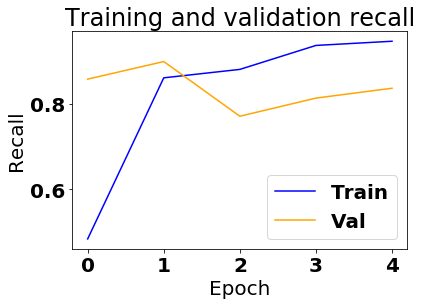

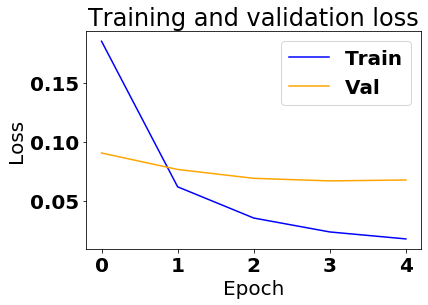

In [45]:
plot(history)

In [104]:
# evaluate the model
word_loss, word_accuracy, word_f1,word_f2, word_precision, word_recall = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f, F1: %f, F2: %f, precision: %f, recall: %f' % (word_accuracy * 100, word_f1 * 100, word_f2 * 100, word_precision*100, word_recall*100))

1828/1828 [==============================] - 0s 98us/step
Accuracy: 97.374179, F1: 87.721708, F2: 86.993035, precision: 91.863428, recall: 87.100135


In [ ]:
word_score = {
    'accuracy': word_accuracy,
    'F1': word_f1,
}
embeddings_scores = { 'Word': word_score }

In [ ]:
# Embedding Layer
embedding_layer = model.layers[0]
embeddings = embedding_layer.get_weights()[0]
print('Embedding Layer shape:', embeddings.shape)

In [ ]:
embeddings[0]

In [ ]:
np.save('../code_embedding/embedding/word_embeddings', embeddings)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)
print('PCA explained variance ratio:', pca.explained_variance_ratio_, 'Total:', sum(pca.explained_variance_ratio_))

In [ ]:
def get_top_words(tokenizer, N=50):
    
    return [word for word, occurrences in sorted(tokenizer.word_counts.items(), key=lambda t: t[1], reverse=True)[:N]]

In [ ]:
top_words = get_top_words(tokenizer)

In [ ]:
def plot_embeddings(low_dim_embs, id_to_word, top_words,id_plot, figsize=(8, 8)):

    plt.figure(figsize=figsize, dpi=100)
    #ax = plt.axes()
    #ax.yaxis.set_major_locator(plt.NullLocator())
    #ax.xaxis.set_major_locator(plt.NullLocator())
    i = 0
    while i < len(low_dim_embs):

        if i in id_to_word:
            
            x, y = low_dim_embs[i, :]
            word = id_to_word[i]

            if word in top_words:
                plt.scatter(x, y, color='b')
                plt.annotate(word,
                            xy=(x, y),
                            xytext=(5, 2),
                            textcoords='offset points',
                            ha='right',
                            va='bottom',
                            fontsize=14)
                plt.title("Embedding projected on PCA space")
        
        i += 1
    plt.savefig('../code_embedding/plots/pca_{}.png'.format(id_plot))

In [ ]:
plot_embeddings(principal_components, id_to_word, top_words,id_plot=0, figsize=(18, 18))

In [ ]:
plot_embeddings(principal_components, id_to_word, get_top_words(tokenizer, 20), id_plot=1)

Measure the distance between vectors:

In [ ]:
from scipy.spatial.distance import euclidean, cosine

def get_vector_distance(embeddings, tok, word1, word2):
    
    return euclidean(embeddings[tok.word_index[word1]], 
                     embeddings[tok.word_index[word2]])
    
def get_vector_cosine_distance(embeddings, tok, word1, word2):
    
    return cosine(embeddings[tok.word_index[word1]], 
                  embeddings[tok.word_index[word2]])

Cosine similarity:

In [ ]:
get_vector_cosine_distance(embeddings, tokenizer, 'x', 'y')

In [ ]:
get_vector_cosine_distance(embeddings, tokenizer, '<<', '=')

In [ ]:
get_vector_cosine_distance(embeddings, tokenizer, '+', '-')

In [ ]:
get_vector_cosine_distance(embeddings, tokenizer, '(', ')')

In [ ]:
get_vector_cosine_distance(embeddings, tokenizer, '{', '}')

Euclidean distance:

In [ ]:
get_vector_distance(embeddings, tokenizer, '<<', '>>')

In [ ]:
get_vector_distance(embeddings, tokenizer, 'x', 'y')

In [ ]:
get_vector_distance(embeddings,tokenizer, 'if', 'elif')

In [ ]:
get_vector_distance(embeddings, tokenizer, 'elif', 'else:')

In [ ]:
get_vector_distance(embeddings, tokenizer, '+', '-')

In [ ]:
get_vector_distance(embeddings, tokenizer, 'for', 'while')

## More complex architecture

In [ ]:
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPooling1D
from sklearn.metrics import f1_score

model = Sequential()
model.add(Embedding(NUM_WORDS, 50, input_length=MAX_LENGTH))
model.add(Conv1D(32, 15, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(32,15, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(32,10, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(32,10, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['acc', f1,f2,precision_,recall_])

print(model.summary())
                    